In [34]:
import warnings
import pandas as pd
import arviz as az

import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
import calendar
from libs.model import HGPforecaster
from libs.metrics import calculate_metrics, metrics_to_table
from libs.pre_processing import generate_groups_data
from libs.visual_analysis import visualize_fit, visualize_predict
import numpy as np
import pymc3 as pm
import theano.tensor as tt
az.style.use('arviz-darkgrid')
warnings.filterwarnings('ignore')

data = pd.read_csv('../data/TourismData_v3.csv')
data['Year'] = data['Year'].fillna(method='ffill')

d = dict((v,k) for k,v in enumerate(calendar.month_name))
data.Month = data.Month.map(d)
data = data.assign(t=pd.to_datetime(data[['Year', 'Month']].assign(day=1))).set_index('t')
data = data.drop(['Year', 'Month'], axis=1)

groups_input = {
    'state': [0,1],
    'zone': [0,2],
    'region': [0,3],
    'purpose': [3,6]
}

groups = generate_groups_data(data, groups_input, seasonality=12, h=8)

Number of groups: 4
	state: 7
	zone: 27
	region: 76
	purpose: 4
Total number of series: 304
Number of points per series for train: 220
Total number of points: 228
Seasonality: 12
Forecast horizon: 8


In [ ]:
X = np.arange(groups['train']['n']).reshape(-1,1)
X_new = np.arange(groups['predict']['n']).reshape(-1,1)

p_s_fit = []
p_s_predict = []

for i in range(groups['train']['s']):    
    with pm.Model() as model:

        period = pm.Gamma('period', 120, 10)


        l_t = pm.Gamma('l_t', 5, 1, testval=0.5)
        l_p = pm.Gamma('l_p', 2, 1, testval=0.5)
        η_trend = pm.HalfNormal('η_trend',0.15, testval=0.5)#, testval=0.15)
        η_per = pm.HalfNormal('η_per',0.5, testval=0.5)
        σ  = pm.HalfNormal("σ",  sigma=0.1)

        a = pm.Normal('a', np.log(np.mean(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])),0.1) 
        #b = pm.Normal('b', mu=0, sd=0.1, testval=0.1)

        mu_func = pm.gp.mean.Constant(a)


        # cov function for the GP 
        cov = (η_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
                + η_per * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
                + pm.gp.cov.WhiteNoise(σ))

        gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
        f = gp.prior('f', X=X, reparameterize=True)

        y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,i])
        mp = pm.find_MAP(maxeval=5000, progressbar = False)
        
        pred_samples_fit = pm.sample_posterior_predictive([mp], 
                                      vars=[y_pred], 
                                      samples=200,
                                      progressbar=False)

        f_n = gp.conditional('f_n', Xnew=X_new)

        y_pred_new = pm.Poisson("y_pred_new", 
                                mu=tt.exp(f_n), 
                                shape=X_new.shape[0])

        pred_samples_predict = pm.sample_posterior_predictive([mp], 
                                                  vars=[y_pred_new], 
                                                  samples=200,
                                                  progressbar = False)

    print(str(i)+'/'+str(groups['train']['s']-1))
    p_s_fit.append(pred_samples_fit['y_pred'])
    p_s_predict.append(pred_samples_predict['y_pred_new'])

p_s_fit = np.asarray(p_s_fit)
p_s_predict = np.asarray(p_s_predict)
p_s_fit = p_s_fit.transpose(1, 0, 2).reshape(200, groups['train']['n']*groups['train']['s'])
p_s_predict = p_s_predict.transpose(1, 0, 2).reshape(200, groups['predict']['n']*groups['predict']['s'])
p_s_fit_d = {}
p_s_predict_d = {}
p_s_fit_d['y_pred'] = p_s_fit
p_s_predict_d['y_pred_new'] = p_s_predict

visualize_fit(groups, p_s_fit_d, 8)

visualize_predict(groups, p_s_predict_d, 8)

results = calculate_metrics(p_s_predict_d, groups)
metrics_to_table(groups, results)

0/303


# Test one series

In [6]:
import matplotlib.pyplot as plt

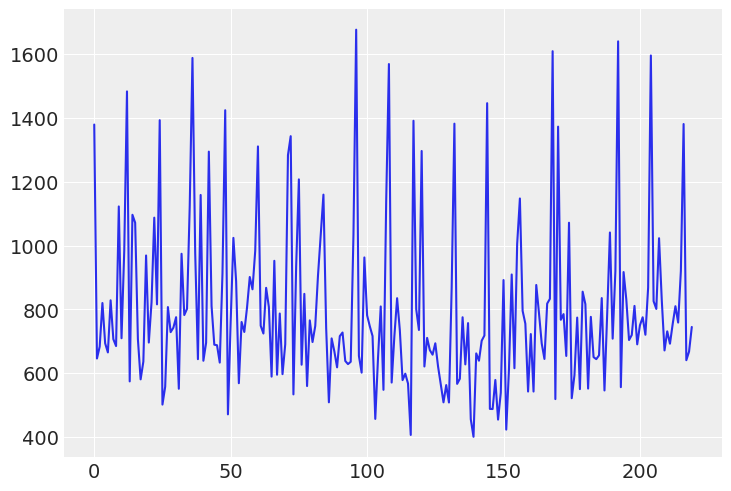

In [100]:
series = 1
plt.plot(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series]);

In [101]:
with pm.Model() as model:
    period = pm.Gamma('period', 120, 10)


    l_t = pm.Gamma('l_t', 5, 1, testval=0.5)
    l_p = pm.Gamma('l_p', 2, 1, testval=0.5)
    η_trend = pm.HalfNormal('η_trend',0.15, testval=0.5)#, testval=0.15)
    η_per = pm.HalfNormal('η_per',0.5, testval=0.5)
    σ  = pm.HalfNormal("σ",  sigma=0.1)

    a = pm.Normal('a', np.log(np.mean(groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])),0.1) 
    #b = pm.Normal('b', mu=0, sd=0.1, testval=0.1)

    mu_func = pm.gp.mean.Constant(a)


    # cov function for the GP 
    cov = (η_trend * pm.gp.cov.ExpQuad(input_dim=1, ls=l_t)
            + η_per * pm.gp.cov.Periodic(1, period=period, ls=l_p) 
            + pm.gp.cov.WhiteNoise(σ))

    gp = pm.gp.Latent(mean_func=mu_func, cov_func=cov)
    f = gp.prior('f', X=X, reparameterize=True)

    y_pred = pm.Poisson('y_pred', mu=tt.exp(f), observed=groups['train']['data'].reshape(groups['train']['s'], groups['train']['n']).T[:,series])
    mp = pm.find_MAP(maxeval=5000, progressbar = True)

In [102]:
mp['a']

array(6.71406828)

In [103]:
mp

{'period_log__': array(2.48561736),
 'l_t_log__': array(-0.59916676),
 'l_p_log__': array(-1.71486719),
 'η_trend_log__': array(-0.83305723),
 'η_per_log__': array(-1.11033204),
 'σ_log__': array(-3.08752857),
 'a': array(6.71406828),
 'f_rotated_': array([ 0.58853121, -0.44957002, -0.10266969,  0.02563444, -0.21126629,
        -0.19767404,  0.06289115, -0.19912223, -0.16591221,  0.41314372,
        -0.29810919,  0.18376336,  0.45454355, -0.46773188,  0.59751195,
         0.22276903, -0.15103742, -0.29819044, -0.24913417,  0.36092034,
        -0.2154585 , -0.09772971,  0.43541073, -0.26835788,  0.34368875,
        -0.5535717 , -0.42917891, -0.03630784, -0.02428381,  0.1055011 ,
         0.00825672, -0.53282109,  0.47211519, -0.28224073, -0.03891368,
         0.31024869,  0.35680413,  0.46979744, -0.32032528,  0.47126054,
        -0.30977146,  0.05231302,  0.73676996, -0.04795093, -0.17681154,
        -0.29228809, -0.34589819,  0.02558336,  0.17891291, -0.62389699,
         0.17088125, 

In [104]:
with pm.Model() as model:
    f_n0 = gp.conditional('f_n0', Xnew=X_new)

    y_pred_new0 = pm.Poisson("y_pred_new0", 
                            mu=tt.exp(f_n0), 
                            shape=X_new.shape[0])

    pred_samples0 = pm.sample_posterior_predictive([mp], 
                                              vars=[y_pred_new0], 
                                              samples=200,
                                              progressbar = False)

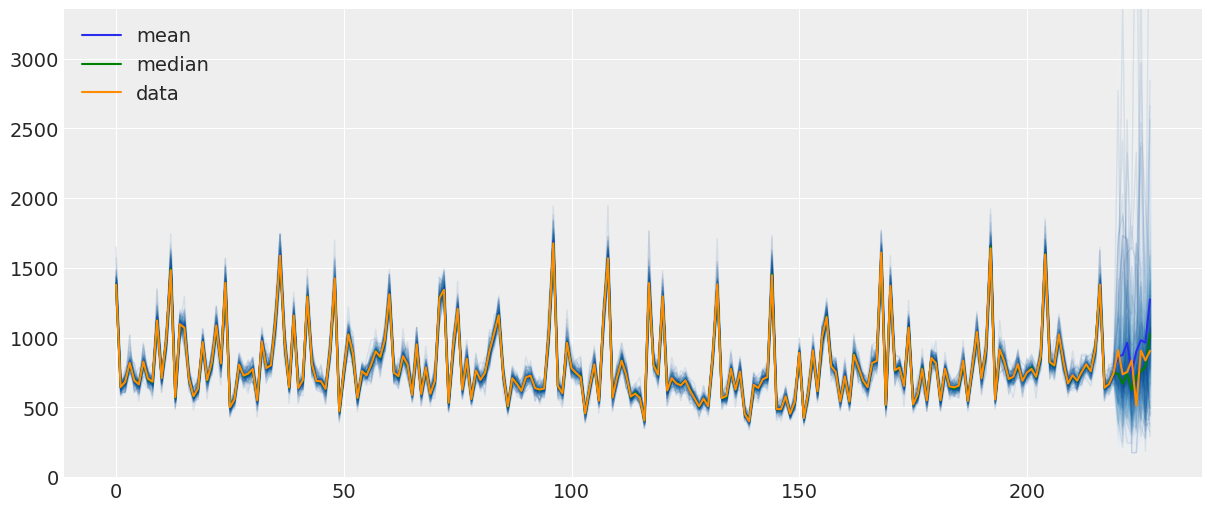

In [105]:
from pymc3.gp.util import plot_gp_dist
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist

plot_gp_dist(ax, pred_samples0['y_pred_new0'], X_new, palette="Blues", fill_alpha=0.1, samples_alpha=0.1);
plt.plot(np.mean(pred_samples0['y_pred_new0'], axis=0), label='mean')
plt.plot(np.median(pred_samples0['y_pred_new0'], axis=0), label='median', color='green')
plt.plot(np.arange(groups['predict']['n']),(groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series]), label='data', color='darkorange')
plt.ylim(0,max((groups['predict']['data'].reshape(groups['predict']['s'], groups['predict']['n']).T[:,series]))*2)
plt.legend();